In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
sys.path.append('../src/')
from utils import *
from config import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

%load_ext autoreload
%autoreload 2

## Data generation

### Features

1- Lets generate $N$ samples from a group of $d_{ind}$ marginally uniformly distributed random variable $x_1,\dots, x_{d_{ind}}$ and indipendent from each other.

2- Then lets generate $N$ samples from a group of $d_{corr}$ marginally uniformly distributed random variable $x_{d_{ind}+1},\dots, x_{d_{corr}}$, which we make correlated via a Gaussian copula (Nelsen 2007) with correlation parameter $\rho$:

In [2]:
seed_everything(1)

N=1000
d_ind = 5
d_corr = 2
ρ = 0.8

features = [f'x{i}' for i in range(1, d_ind+d_corr+1)]

Σ1 = np.eye(d_ind)
Σ2 = np.full(shape=(d_corr, d_corr), fill_value=ρ) + np.eye(d_corr) * (1-ρ)
Σ = block_diag(Σ1, Σ2)
X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
X = norm.cdf(X)

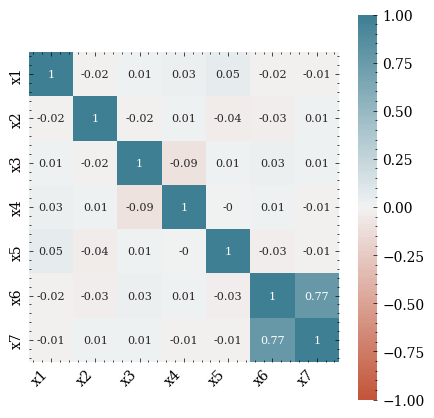

In [3]:
fig_params.update({'figure.figsize': [5,5]})
rcParams.update(fig_params)
ax = sns.heatmap(pd.DataFrame(data=X, columns=features).corr().round(2), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 square=True, annot=True, annot_kws={"fontsize":8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Target

Lets generate the target variable as a linear combination of the group of indipendent input features and **one** from the group of correlated input features, with additive gaussian noise. 

$$
y = \sum_{i=1}^{d_{ind}} \beta_ix_i + \beta_jx_j + \epsilon , \quad j\in\{d_{ind}+1,\dots, d_{corr}\}
$$

with $\epsilon \sim \mathcal{N}(\mu_y=0,\sigma_y^2)$ and the $\beta$ coefficients defined below.

In [4]:
seed_everything(1)

β_ind = [1.0]*d_ind
β_corr = 1.5
μy = 0
σy = 0.5

β = np.array(β_ind + [β_corr])
y = X[:,:d_ind+1] @ β + σy * np.random.randn(N) + μy

target = 'y'

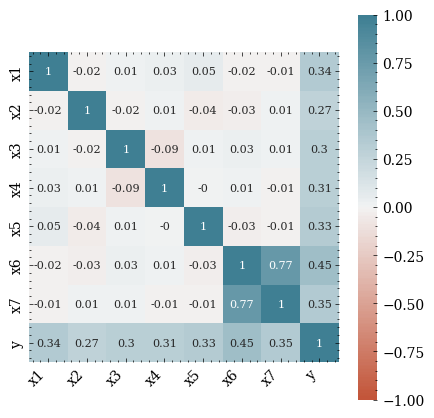

In [5]:
fig_params.update({'figure.figsize': [5,5]})
rcParams.update(fig_params)
ax = sns.heatmap(pd.DataFrame(data=np.hstack((X, y.reshape(-1,1))), columns=features+['y']).corr().round(2), vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), square=True, annot=True, annot_kws={"fontsize":8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Training

In [6]:
seed_everything(1)

comb = pd.DataFrame(data=np.hstack([X, y.reshape(-1,1)]), columns= features + [target])
X_train, X_test, y_train, y_test = train_test_split(comb[features], comb[target], random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train);

In [7]:
print(f'RF train R2: {model.score(X_train, y_train):.3f}')
print(f'RF test R2: {model.score(X_test, y_test):.3f}')

RF train R2: 0.943
RF test R2: 0.688


## Permutation Feature Importance (PFI) 

In [8]:
result = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=0, n_jobs=-1)

features_ind = [f'x{i}' for i in range(1, d_ind+1)]
features_corr = [f'x{i}' for i in range(d_ind+1, d_ind+d_corr+1)]
features = features_ind + features_corr

idx1 = pd.MultiIndex.from_product([['indipendent'], features_ind])
idx2 = pd.MultiIndex.from_product([['correlated'], features_corr])
idx = pd.MultiIndex.from_tuples(list(idx1.values) + list(idx2.values), names=['type', 'feature'])
imp_df = pd.DataFrame(data=result.importances, index=idx)

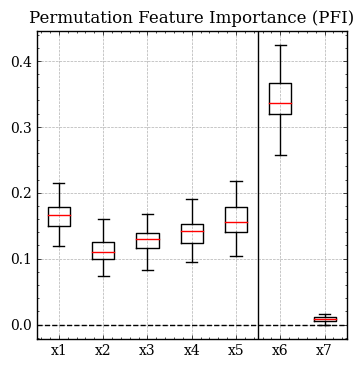

In [10]:
fig_params.update({'figure.figsize': [4,4]})
rcParams.update(fig_params)

boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
capprops = dict(linestyle='-', linewidth=1, color='k')
ax = imp_df.reset_index([0],drop=True).T.boxplot(column=features[:7], showfliers=False,
                                                        boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops)
ax.axhline(0.0, linestyle='--', color='k')
ax.axvline(5.5, color = 'k', linestyle='-')
ax.set_title('Permutation Feature Importance (PFI)');

## Simulation

### Sensitivity to the number of correlated variables $d_{corr}$

In [11]:
seed_everything(1)

N = 1000
d_ind = 5
ρ = 0.8
d_corr_list = [1, 5, 10, 25, 50, 75]

β_ind = [1.0]*d_ind
β_corr = 1.5
μy = 0
σy = 0.5

target = 'y'

imp_df_list = []
scores = {}

for d_corr in tqdm(d_corr_list):
    scores[d_corr] = {}
    
    Σ1 = np.eye(d_ind)
    Σ2 = np.full(shape=(d_corr, d_corr), fill_value=ρ) + np.eye(d_corr) * (1-ρ)
    Σ = block_diag(Σ1, Σ2)
    X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
    X = norm.cdf(X)

    β = np.array(β_ind + [β_corr])
    y = X[:,:d_ind+1] @ β + σy * np.random.randn(N) + μy

    features_ind = [f'x{i}' for i in range(1, d_ind+1)]
    features_corr = [f'x{i}' for i in range(d_ind+1, d_ind+d_corr+1)]
    features = features_ind + features_corr

    df = pd.DataFrame(data=np.hstack([X, y.reshape(-1,1)]), columns= features + [target])
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)
    model = RandomForestRegressor(max_features=0.7)
    model.fit(X_train, y_train)
    scores[d_corr]['train_R2'] = model.score(X_train, y_train)
    scores[d_corr]['test_R2'] = model.score(X_test, y_test)
    result = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=0, n_jobs=-1)
    idx1 = pd.MultiIndex.from_product([[d_corr], ['indipendent'], features_ind])
    idx2 = pd.MultiIndex.from_product([[d_corr], ['correlated'], features_corr])
    idx = pd.MultiIndex.from_tuples(list(idx1.values) + list(idx2.values), names=['correlated features', 'type', 'feature'])
    imp_df_tmp = pd.DataFrame(data=result.importances, index=idx)
    imp_df_list.append(imp_df_tmp)
imp_df = pd.concat(imp_df_list)

  0%|          | 0/6 [00:00<?, ?it/s]

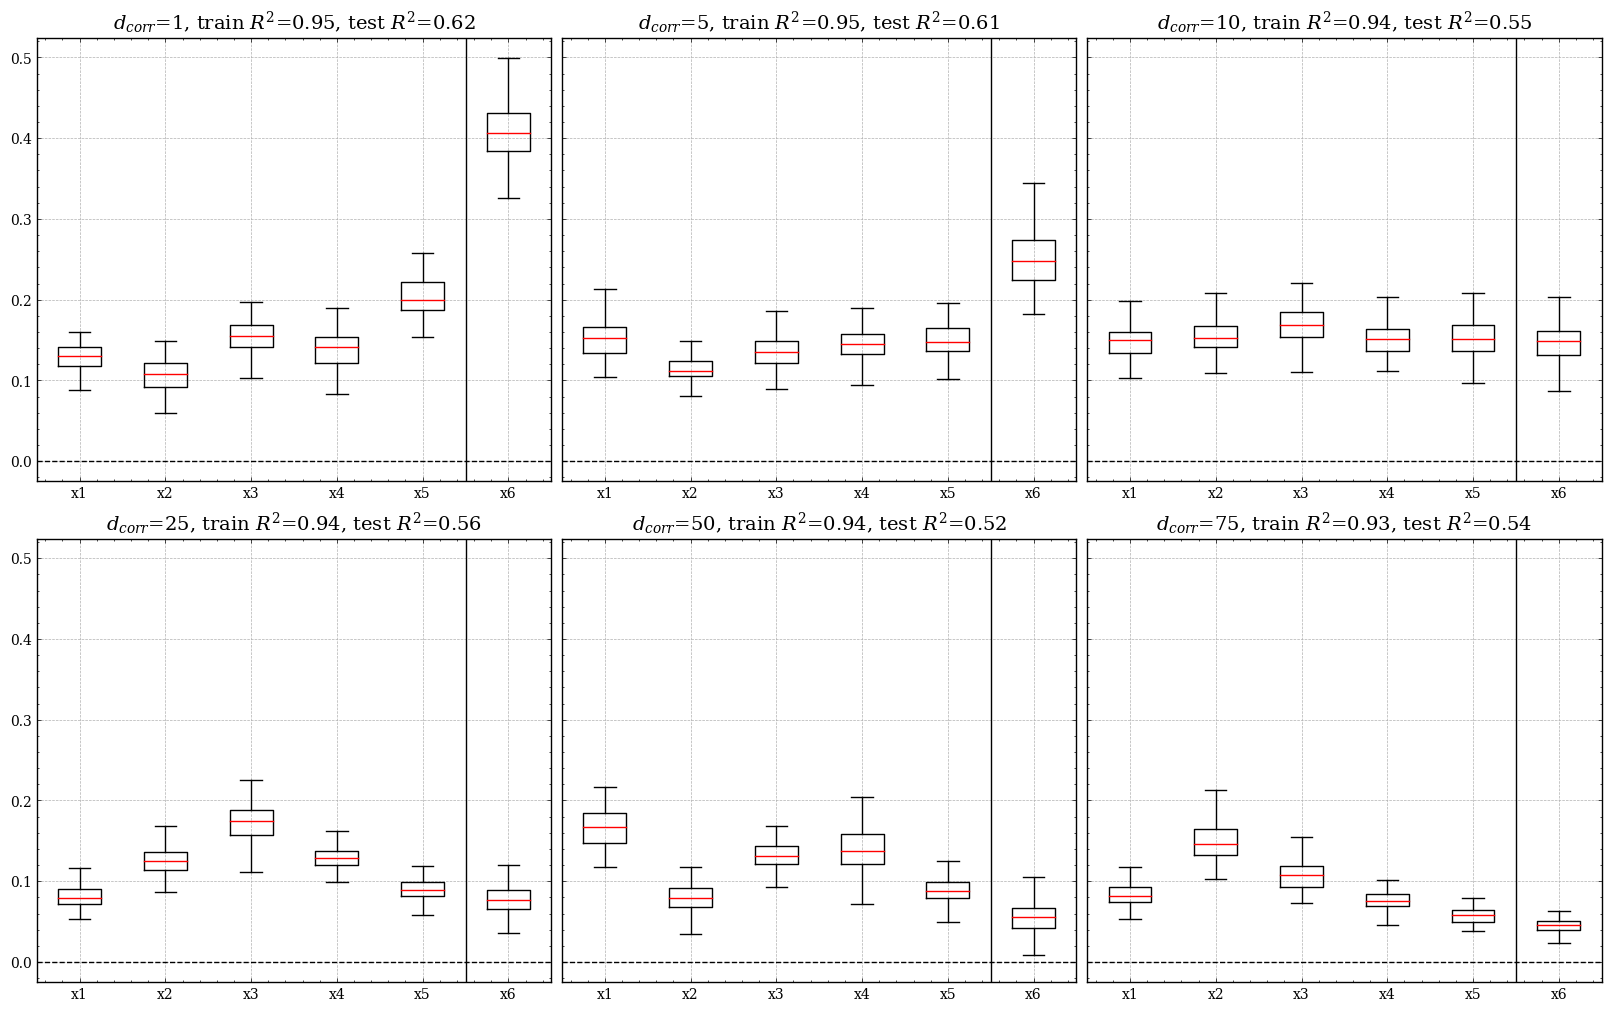

In [12]:
fig_params.update({'figure.figsize': [16, 10]})
rcParams.update(fig_params)
fig, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True, sharex=False, sharey=True)
axes = axes.reshape(3*2)
for i, d_corr in enumerate(d_corr_list):
    train_r2 = scores[d_corr]['train_R2'].round(2)
    test_r2 = scores[d_corr]['test_R2'].round(2)
    features_ind = [f'x{i}' for i in range(1, d_ind+1)]
    features_corr = [f'x{i}' for i in range(d_ind+1, d_ind+d_corr+1)]
    features = features_ind + features_corr
    boxprops = dict(linestyle='-', linewidth=1, color='k')
    medianprops = dict(linestyle='-', linewidth=1, color='r')
    whiskerprops = dict(linestyle='-', linewidth=1, color='k')
    capprops = dict(linestyle='-', linewidth=1, color='k')
    imp_df.loc[d_corr].reset_index([0],drop=True).T.boxplot(column=features[:6], ax=axes[i], showfliers=False,
                                                            boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops)
    axes[i].set_title(fr'$d_{{corr}}$={d_corr}, train $R^{{2}}$={train_r2}, test $R^{{2}}$={test_r2}', fontsize=14)
    axes[i].axhline(0.0, linestyle='--', color='k')
    axes[i].axvline(5.5, color = 'k', linestyle='-')

### Sensitivity to correlation amount

In [13]:
seed_everything(1)

N=1000
d_ind = 5
d_corr = 10
ρ_list = [0.0, 0.8, 0.9, 0.95, 0.99, 0.999]

β_ind = [1.0]*d_ind
β_corr = 1.5
μy = 0
σy = 0.5

features_ind = [f'x{i}' for i in range(1,d_ind+1)]
features_corr = [f'x{i}' for i in range(d_ind+1, d_ind+d_corr+1)]
features = features_ind + features_corr
target = 'y'

imp_df_list = []
scores = {}

for ρ in tqdm(ρ_list):
    scores[ρ] = {}
    
    Σ1 = np.eye(d_ind)
    Σ2 = np.full(shape=(d_corr, d_corr), fill_value=ρ) + np.eye(d_corr) * (1-ρ)
    Σ = block_diag(Σ1, Σ2)
    X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
    X = norm.cdf(X)

    β = np.array(β_ind + [β_corr])
    y = X[:,:d_ind+1] @ β + σy * np.random.randn(N) + μy

    df = pd.DataFrame(data=np.hstack([X, y.reshape(-1,1)]), columns= features + [target])
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)
    model = RandomForestRegressor(max_features=0.7)
    model.fit(X_train, y_train)
    scores[ρ]['train_R2'] = model.score(X_train, y_train)
    scores[ρ]['test_R2'] = model.score(X_test, y_test)
    result = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=0, n_jobs=-1)
    idx1 = pd.MultiIndex.from_product([[ρ], ['indipendent'], features_ind])
    idx2 = pd.MultiIndex.from_product([[ρ], ['correlated'], features_corr])
    idx = pd.MultiIndex.from_tuples(list(idx1.values) + list(idx2.values), names=['correlation', 'type', 'feature'])
    imp_df_tmp = pd.DataFrame(data=result.importances, index=idx)
    imp_df_list.append(imp_df_tmp)
imp_df = pd.concat(imp_df_list)

  0%|          | 0/6 [00:00<?, ?it/s]

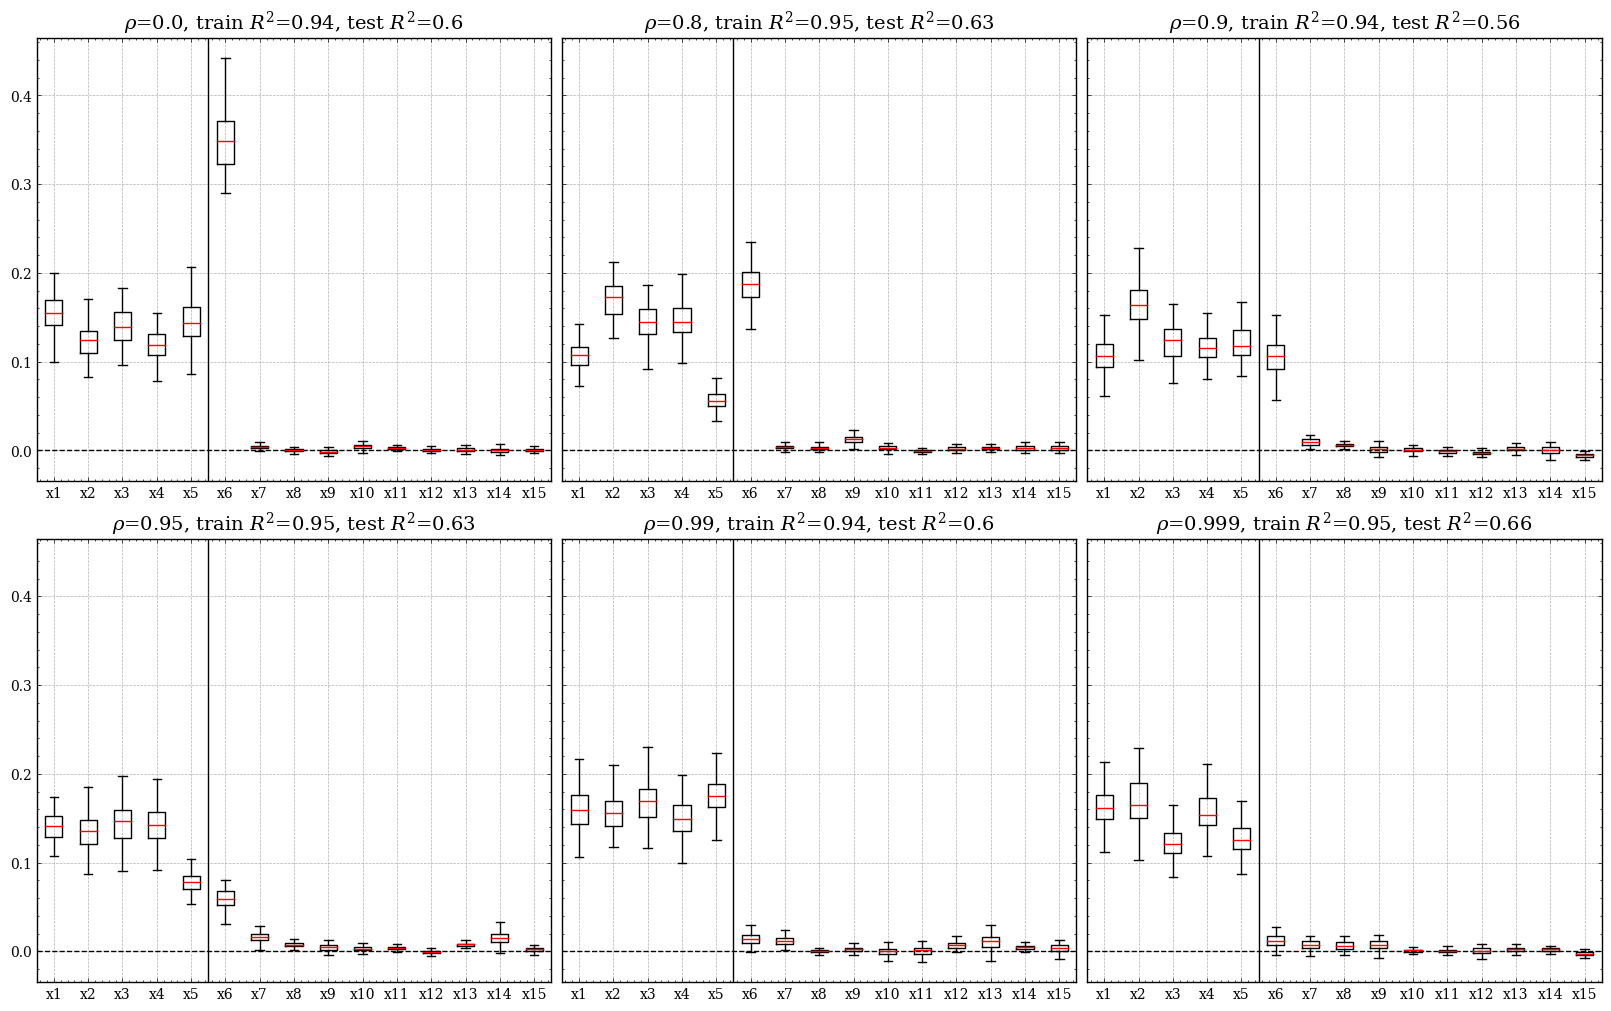

In [14]:
fig_params.update({'figure.figsize': [16, 10]})
rcParams.update(fig_params)
fig, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True, sharex=False, sharey=True)
axes = axes.reshape(3*2)
for i, ρ in enumerate(ρ_list):
    train_r2 = scores[ρ]['train_R2'].round(2)
    test_r2 = scores[ρ]['test_R2'].round(2)
    boxprops = dict(linestyle='-', linewidth=1, color='k')
    medianprops = dict(linestyle='-', linewidth=1, color='r')
    whiskerprops = dict(linestyle='-', linewidth=1, color='k')
    capprops = dict(linestyle='-', linewidth=1, color='k')
    imp_df.loc[ρ].reset_index([0],drop=True).T.boxplot(column=features, ax=axes[i], showfliers=False,
                                                            boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops)
    axes[i].set_title(fr'$\rho$={ρ}, train $R^{{2}}$={train_r2}, test $R^{{2}}$={test_r2}', fontsize=14)
    axes[i].axvline(5.5, color = 'k', linestyle='-')
    axes[i].axhline(0, color = 'k', linestyle='--')

## References

Nelsen, Roger B. An introduction to copulas. Springer Science & Business Media, 2007.